<a href="https://colab.research.google.com/github/M-Waweru/ML_Unit/blob/master/ML_TaskTwo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits import mplot3d 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data (3).csv


In [3]:
df = pd.read_csv('train_data.csv')
# Dropping Id column
df.drop(columns='Id', inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Dealing with Null values

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64


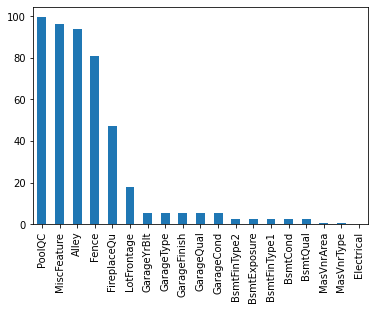

In [4]:
# Getting percentage of missing values in columns with null values
null_check = ((df.isnull().sum())/1460) * 100

null_cols = null_check[null_check > 0]
print(null_cols)
null_cols.sort_values(ascending = False).plot(kind='bar')

# Question i

In [5]:
with_null_df = df.copy()

for col in null_cols.index:
  # If the column is a float, replace the null value with None
  if with_null_df[col].dtype == 'float64':
    with_null_df[col].replace(np.nan, 0, inplace=True)
  elif with_null_df[col].dtype == 'object':
    with_null_df[col].replace(np.nan, 'None', inplace=True)
  else:
    with_null_df['Electrical'].replace('None', 'SBrkr', inplace=True)

with_null_df.columns.isnull().any()

False

In [6]:
with_null_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


# Data Processing

In [7]:
with_null_df['OverallCond'] = with_null_df['OverallCond'].astype('category')
with_null_df['OverallQual'] = with_null_df['OverallQual'].astype('category')

categorical_df = with_null_df.select_dtypes(include=['object']).copy()
process_df = with_null_df.copy()

nominal = ['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'BldgType', 'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
column_names = list(categorical_df.columns)

for feature in column_names:
  process_df[feature] = process_df[feature].astype('category')

for feature in ordinal:
  process_df[feature] = process_df[feature].cat.codes


process_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,3,Lvl,0,Inside,0,CollgCr,Norm,Norm,0,5,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,2,4,PConc,2,4,3,2,706,6,0,150,856,GasA,0,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,Attchd,2003.0,2,2,548,5,5,Y,0,61,0,0,0,0,3,4,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,3,Lvl,0,FR2,0,Veenker,Feedr,Norm,0,2,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,4,CBlock,2,4,1,0,978,6,0,284,1262,GasA,0,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,Attchd,1976.0,2,2,460,5,5,Y,298,0,0,0,0,0,3,4,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,0,Lvl,0,Inside,0,CollgCr,Norm,Norm,0,5,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,2,4,PConc,2,4,2,2,486,6,0,434,920,GasA,0,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,Attchd,2001.0,2,2,608,5,5,Y,0,42,0,0,0,0,3,4,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,0,Lvl,0,Corner,0,Crawfor,Norm,Norm,0,5,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,4,BrkTil,4,1,3,0,216,6,0,540,756,GasA,2,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,Detchd,1998.0,3,3,642,5,5,Y,0,35,272,0,0,0,3,4,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,0,Lvl,0,FR2,0,NoRidge,Norm,Norm,0,5,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,2,4,PConc,2,4,0,2,655,6,0,490,1145,GasA,0,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,Attchd,2000.0,2,3,836,5,5,Y,192,84,0,0,0,0,3,4,None,0,12,2008,WD,Normal,250000


In [8]:
dummies_df = process_df.copy()

for feature in nominal:
  dummy_df = pd.get_dummies(dummies_df[feature], prefix=feature)
  dummies_df = pd.concat([dummies_df, dummy_df], axis=1)
  dummies_df.drop(feature, axis=1, inplace=True)

dummies_df.head()

,MSSubClass,LotFrontage,LotArea,LotShape,Utilities,LandSlope,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,3,0,0,0,5,7,5,2003,2003,196.0,2,4,2,4,3,2,706,6,0,150,856,0,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,3,0,0,0,2,6,8,1976,1976,0.0,3,4,2,4,1,0,978,6,0,284,1262,0,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,0,0,0,0,5,7,5,2001,2002,162.0,2,4,2,4,2,2,486,6,0,434,920,0,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,0,0,0,0,5,7,5,1915,1970,0.0,3,4,4,1,3,0,216,6,0,540,756,2,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,0,0,0,0,5,8,5,2000,2000,350.0,2,4,2,4,0,2,655,6,0,490,1145,0,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [9]:
# Turning dataframe to a matrix
X = dummies_df.drop(['SalePrice'], axis=1).values
y = dummies_df['SalePrice'].values
X

array([[60, 65.0, 8450, ..., 0, 1, 0],
       [20, 80.0, 9600, ..., 0, 1, 0],
       [60, 68.0, 11250, ..., 0, 1, 0],
       ...,
       [70, 66.0, 9042, ..., 0, 1, 0],
       [20, 68.0, 9717, ..., 0, 1, 0],
       [20, 75.0, 9937, ..., 0, 1, 0]], dtype=object)

In [10]:
# Standardisation of the dataset
X = StandardScaler().fit_transform(X)
X

array([[ 0.07337496,  0.2128772 , -0.20714171, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276,  0.64574726, -0.09188637, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.07337496,  0.29945121,  0.07347998, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.30985939,  0.2417352 , -0.14781027, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276,  0.29945121, -0.08016039, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276,  0.50145724, -0.05811155, ..., -0.11785113,
         0.4676514 , -0.30599503]])

# Question ii

Getting the first 2 PCA

In [11]:
first_pca = PCA(n_components=2)
pc_s = first_pca.fit_transform(X)
pca_data = pd.DataFrame(pc_s, columns=['Principal Component 1', 'Principal Component 2'])

pca_data = pd.concat([pca_data, dummies_df['SalePrice']], axis=1)
pca_data.head()

,Principal Component 1,Principal Component 2,SalePrice
0,3.176041,0.534875,208500
1,-0.287656,-2.886769,181500
2,3.517767,0.183408,223500
3,-2.016640,0.753767,140000
4,5.448307,0.064712,250000


In [12]:
print('First Principal Component -> ', first_pca.explained_variance_ratio_[0]*100)
print('Second Principal Component -> ', first_pca.explained_variance_ratio_[1]*100)

print('Total percentage -> ', first_pca.explained_variance_ratio_.sum()*100)

First Principal Component ->  6.6730217146062
Second Principal Component ->  3.2948195574211137
Total percentage ->  9.967841272027314


# Question iii

Percentage of data in the first 2 PCA is **9.9678%**

# Question iv

In [13]:
info_percent = 0
counter = 100

while info_percent < 0.9:
  counter+=1
  second_pca = PCA(n_components=counter)
  pc_s = second_pca.fit_transform(X)
  info_percent = second_pca.explained_variance_ratio_.sum()
  print(info_percent)

print(counter)

0.8299639822124373
0.8334495866930877
0.8370870090919282
0.8408552965333151
0.8445002656515409
0.8481576295385279
0.8517052798299471
0.8552518450143487
0.8587465686230517
0.8617082207373525
0.8650065510765911
0.8685404135485975
0.8719093346786955
0.8750712692638922
0.8783181736882923
0.8815701199622507
0.8844818825466498
0.8876759627641031
0.8905438786046508
0.8939262992652637
0.8969419242570095
0.8997901344853008
0.9030124908208371
123


The number of PCA required to have 90% are **123**

# Question v

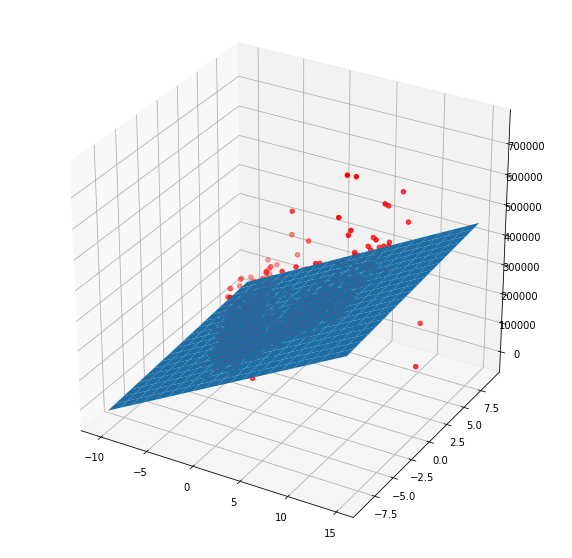

In [39]:
X_train = pca_data.drop(['SalePrice'], axis=1).values
y_train = pca_data['SalePrice'].values

regressor = LassoCV().fit(X_train, y_train)

min_value = np.min(pca_data, axis=0)
max_value = np.max(pca_data, axis=0)
plot_x, plot_y = np.meshgrid(np.linspace(min_value[0], max_value[0], 20), np.linspace(min_value[1], max_value[1], 20))

w1 = regressor.coef_[0]
w2 = regressor.coef_[1]
b = regressor.intercept_
z = w1 * plot_x + w2 * plot_y + b

fig = plt.figure().gca(projection='3d')
plt.rcParams['figure.figsize'] = (10, 10)
fig.plot_surface(plot_x, plot_y, z)
fig.scatter(pca_data['Principal Component 1'], pca_data['Principal Component 2'], pca_data['SalePrice'], c='r')

plt.show()

In [40]:
print('w1 -> ', w1)
print('w2 -> ', w2)
print('y-intercept -> ', b)

w1 ->  16757.06850953566
w2 ->  2462.789662682156
y-intercept ->  180921.19589041095


y = 16757.06851x1 + 2462.78966x2 + 180921.19589